<a href="https://colab.research.google.com/github/nahbroimmadomyownthing/datacancer/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIbraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

**Pre-procsessed images**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Reading the data
path = 'content\drive\MyDrive\data\negr'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [5]:
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'

}

In [6]:
import pandas as pd

skin_df = pd.read_csv('/content/drive/MyDrive/data/negr/negrnegr.csv')

print(skin_df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [7]:
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [8]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           0 non-null      object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [13]:
!pip install opencv-python tqdm

import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm

IMAGE_SIZE = 71
IMAGE_FOLDER = '/content/drive/MyDrive/data2/negr/all_images'

def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  if img is None:
    print(f"Failed to load image: {img_path}")
    return None
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img

image_files = [f for f in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, f))]

train_img = []

for image_file in tqdm(image_files):
    img_path = os.path.join(IMAGE_FOLDER, image_file)
    img = read_img(img_path)
    if img is not None:
        train_img.append(img)

X = np.array(train_img, np.float32) / 255
print(X.shape)

100%|██████████| 10015/10015 [04:38<00:00, 35.92it/s]


(10015, 71, 71, 3)


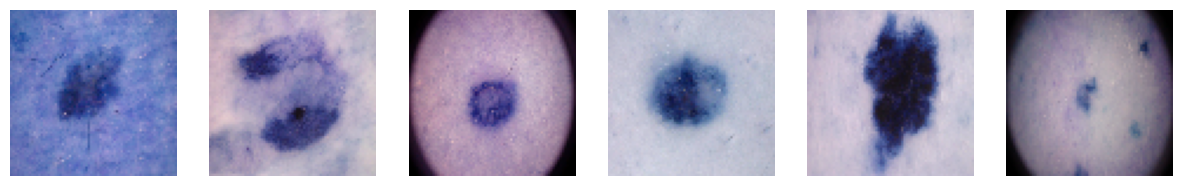

In [14]:
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [15]:
y = np.array(skin_df['cell_type_idx'])

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

In [18]:
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True

In [19]:
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [20]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 71, 71, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 23,222,319 (88.59 MB)

 Trainable params: 23,167,535 (88.38 MB)

 Non-trainable params: 54,784 (214.00 KB)

In [10]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [23]:
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 104s 168ms/step - accuracy: 0.4880 - loss: 1.5121 - val_accuracy: 0.7173 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.7167 - loss: 0.9780 - val_accuracy: 0.7262 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 3/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7317 - loss: 0.9036 - val_accuracy: 0.7239 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.7338 - loss: 0.8938 - val_accuracy: 0.7284 - val_loss: 1.3025 - learning_rate: 0.0010
Epoch 5/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7363 - loss: 0.8920 - val_accuracy: 0.7417 - val_loss: 3.8515 - learning_rate: 0.0010
Epoch 6/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.7386 - loss: 0.8751 - val_accuracy: 0.6840 - val_loss: 1.0088 - learning_rate: 0.0010
Epoch 7/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7462 -

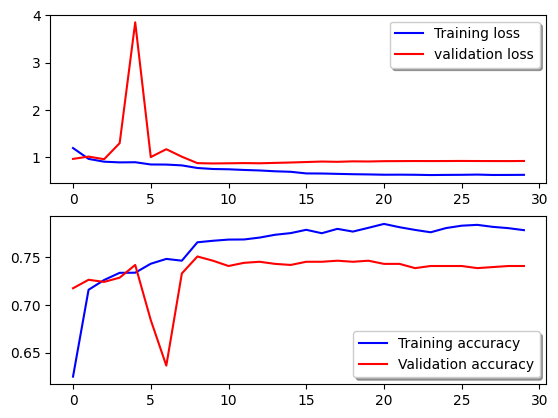

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [25]:
model2 = Model(model.input,model.layers[-4].output)
predictions = model2.predict(X)
predictions[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step


array([-16.40102   ,  38.447475  ,  -4.281368  ,  38.292442  ,
       -11.858595  ,  -8.646056  , -46.59341   , -42.18174   ,
       -18.251102  , -17.967443  , -17.11051   ,  11.729183  ,
        40.755257  , -12.463726  ,  48.228127  ,  -3.1291516 ,
        32.959614  , -13.8240185 , -15.842363  , -27.266977  ,
       -27.804478  , -30.265968  ,  70.57747   ,   9.6989565 ,
        39.796947  ,  -6.4139185 ,   9.142173  , -31.743443  ,
       -74.381805  ,  -5.228124  , -43.003853  , -31.071661  ,
       -17.07834   , -54.937553  , -12.224874  ,  38.635063  ,
       -20.256317  ,  -3.4334834 , -17.27814   , -14.545113  ,
       -10.057319  ,  40.430466  , -61.83044   ,  22.496962  ,
       -19.4158    , -13.001441  , -47.87158   ,  31.080662  ,
        -5.6068897 ,  42.905884  ,   6.344122  , -22.953342  ,
       -22.977575  , -10.082179  , -23.420414  ,   3.3721702 ,
       -19.422554  , -10.684209  ,  18.756897  ,  37.24656   ,
        10.637366  ,  -6.996994  ,  17.62017   , -36.02

In [26]:
print(len(predictions[0]))

128


In [27]:
X[0]

array([[[0.83137256, 0.7019608 , 0.7254902 ],
        [0.827451  , 0.69803923, 0.73333335],
        [0.83137256, 0.7058824 , 0.7372549 ],
        ...,
        [0.80784315, 0.69803923, 0.7372549 ],
        [0.8039216 , 0.6862745 , 0.7254902 ],
        [0.8       , 0.69411767, 0.7411765 ]],

       [[0.827451  , 0.7058824 , 0.73333335],
        [0.827451  , 0.69411767, 0.72156864],
        [0.81960785, 0.70980394, 0.74509805],
        ...,
        [0.80784315, 0.69803923, 0.73333335],
        [0.8039216 , 0.68235296, 0.7372549 ],
        [0.7921569 , 0.68235296, 0.7254902 ]],

       [[0.8117647 , 0.6745098 , 0.7254902 ],
        [0.8156863 , 0.69803923, 0.7176471 ],
        [0.827451  , 0.70980394, 0.7411765 ],
        ...,
        [0.7882353 , 0.6901961 , 0.7411765 ],
        [0.78039217, 0.6784314 , 0.73333335],
        [0.7764706 , 0.6862745 , 0.7176471 ]],

       ...,

       [[0.79607844, 0.6862745 , 0.73333335],
        [0.8       , 0.69803923, 0.72156864],
        [0.78431374, 0

In [28]:
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [29]:
model_json = model2.to_json()
with open("model_v2.json", "w") as json_file:
    json_file.write(model_json)

completemodel_json = model.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [30]:
model2.save_weights("model_v2_weights.weights.h5")
print("Saved model to disk")

model.save_weights("completeweights.weights.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [31]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [32]:
complete_data.columns

Index([    'lesion_id',      'image_id',            'dx',       'dx_type',
                 'age',           'sex',  'localization',          'path',
           'cell_type', 'cell_type_idx',
       ...
                   118,             119,             120,             121,
                   122,             123,             124,             125,
                   126,             127],
      dtype='object', length=138)

In [33]:
dxtype_df = pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data = pd.concat([dxtype_df,complete_data],axis=1)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,118,119,120,121,122,123,124,125,126,127
0,False,False,False,True,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,False,False,False,True,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,False,False,False,True,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,False,False,False,True,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,False,False,True,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [34]:
local_df = pd.get_dummies(complete_data['localization'],drop_first=False)
complete_data = pd.concat([local_df,complete_data],axis=1)
complete_data.head()

,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,...,118,119,120,121,122,123,124,125,126,127
0,False,False,False,False,False,False,False,False,False,False,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,False,False,False,False,False,False,False,False,False,False,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,False,False,False,False,False,False,False,False,False,False,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,False,False,False,False,False,False,False,False,False,False,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,False,False,False,True,False,False,False,False,False,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [35]:
sex_df = pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data = pd.concat([sex_df,complete_data],axis=1)
complete_data.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,False,True,False,False,False,False,False,False,False,False,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,False,True,False,False,False,False,False,False,False,False,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,False,True,False,False,False,False,False,False,False,False,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,False,True,False,False,False,False,False,False,False,False,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,True,False,False,False,False,True,False,False,False,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [36]:
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx','sex','path','localization'],axis=1,inplace=False)
y_label = complete_data['cell_type_idx']

In [37]:
X_labels.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,False,True,False,False,False,False,False,False,False,False,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227989,-44.490658,1.901858,-8.362359,34.194031
1,False,True,False,False,False,False,False,False,False,False,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416779,-37.834469,-38.611900,2.578186,-8.230736,30.792984
2,False,True,False,False,False,False,False,False,False,False,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909248,1.194873,-11.622867,52.971333
3,False,True,False,False,False,False,False,False,False,False,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,True,False,False,False,False,True,False,False,False,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [38]:
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step


array([[0.00283286, 0.00371622, 0.5699114 , ..., 0.02262415, 0.379986  ,
        0.00185127],
       [0.09347183, 0.15187176, 0.00936196, ..., 0.6023934 , 0.0369509 ,
        0.07933949],
       [0.05841412, 0.07865876, 0.00861064, ..., 0.7826788 , 0.03610021,
        0.02445582],
       ...,
       [0.08481843, 0.13090487, 0.00413139, ..., 0.66438776, 0.0351298 ,
        0.06192769],
       [0.04939178, 0.070049  , 0.02376333, ..., 0.780078  , 0.04518001,
        0.01868951],
       [0.11461208, 0.16730312, 0.01929676, ..., 0.4988216 , 0.06324825,
        0.09309569]], dtype=float32)

In [39]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [40]:
lst

[2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,


In [41]:
confusion_matrix(lst,y_test)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  89,   2,   8,  79,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [ 33,  50,  21,  10, 663,  32,  14],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

In [42]:
accuracy_score(lst,y_test)

0.7504990019960079

In [43]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        51
           2       0.50      0.81      0.62       110
           3       0.00      0.00      0.00        12
           4       0.81      0.99      0.89       671
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        14

    accuracy                           0.75      1002
   macro avg       0.19      0.26      0.21      1002
weighted avg       0.59      0.75      0.66      1002



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
skin_df = pd.read_csv('skin_cancer_v2.csv')
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,False,True,False,False,False,False,False,False,False,False,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227990,-44.490658,1.901858,-8.362359,34.194030
1,False,True,False,False,False,False,False,False,False,False,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416780,-37.834470,-38.611900,2.578186,-8.230736,30.792984
2,False,True,False,False,False,False,False,False,False,False,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909250,1.194873,-11.622867,52.971333
3,False,True,False,False,False,False,False,False,False,False,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,True,False,False,False,False,True,False,False,False,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [45]:
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,False,True,False,False,False,False,False,False,False,False,...,37.448494,-9.483269,-14.343044,-31.796227,-61.298130,-45.227990,-44.490658,1.901858,-8.362359,34.194030
1,False,True,False,False,False,False,False,False,False,False,...,32.927223,-8.319866,-14.041305,-29.023457,-55.416780,-37.834470,-38.611900,2.578186,-8.230736,30.792984
2,False,True,False,False,False,False,False,False,False,False,...,58.033737,-13.998425,-21.775906,-47.546864,-92.290115,-66.720314,-66.909250,1.194873,-11.622867,52.971333
3,False,True,False,False,False,False,False,False,False,False,...,15.489785,-7.319761,-0.423944,-11.625752,-24.876873,-30.846020,-25.179348,-4.762920,-0.447076,13.534708
4,False,True,False,False,False,False,True,False,False,False,...,-6.457361,-9.250223,19.013042,9.329105,9.783363,16.960728,15.676559,-8.657921,12.938499,-6.282208


In [46]:
X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization','path','cell_type','cell_type_idx','age'],axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

<Axes: >

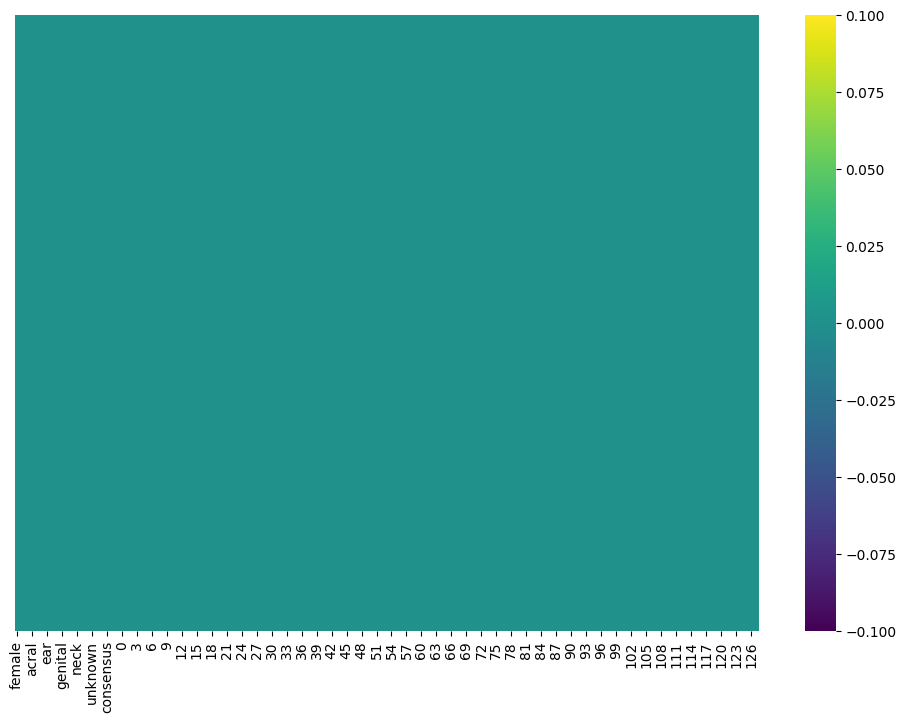

In [47]:
plt.figure(figsize=(12,8))
sns.heatmap(X_labels.isnull(),cmap='viridis',yticklabels=False)

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,test_size=0.10,random_state=28,stratify=y_label)

In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [50]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization','path','cell_type','cell_type_idx','age'],axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,test_size=0.10,random_state=28,stratify=y_label)


imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_imputed, y_train)
y_pred = lr.predict(X_test_imputed)

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.19      0.12      0.15        33
           1       0.10      0.02      0.03        51
           2       0.64      0.41      0.50       110
           3       1.00      0.08      0.15        12
           4       0.84      0.97      0.90       671
           5       0.52      0.58      0.54       111
           6       0.00      0.00      0.00        14

    accuracy                           0.77      1002
   macro avg       0.47      0.31      0.33      1002
weighted avg       0.72      0.77      0.73      1002



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(accuracy_score(y_test,y_pred))

0.7674650698602794
